## Steady-state superradiance

Notebook author: Nathan Shammah (nathan.shammah at gmail.com)


We consider a system of $N$ two-level systems (TLSs) with identical frequency $\omega_{0}$, incoherently pumped at a rate $\gamma_\text{P}$ and de-excitating at a collective emission rate $\gamma_\text{CE}$,

\begin{eqnarray}
\dot{\rho} &=&-i\lbrack \omega_{0}J_z,\rho \rbrack
+\frac{\gamma_\text {CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\text{P}}{2}\sum_{n=1}^{N}\mathcal{L}_{J_{+,n}}[\rho]
\end{eqnarray}
This system can sustain superradiant light emission and line narrowing [1-3],  whose peak intensity scales proportionally to $N^2$.

It is then natural to ask the question of whether the system sustains a superradiant light emission steady state also when local losses are included, just like for the transient superfluorescent light emission [4]. We thus study also
\begin{eqnarray}
\dot{\rho} &=&-i\lbrack \omega_{0}J_z,\rho \rbrack
+\frac{\gamma_\text {CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\sum_{n=1}^{N}\left(\frac{\gamma_\text{P}}{2}\mathcal{L}_{J_{+,n}}[\rho]+
\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]\right)
\end{eqnarray}
and apply the detailed balance condition to the local emission and pumping rates. This study has relevance to the application of superradiance in light-harvesting devices. 

In [1]:
import matplotlib.pyplot as plt
from qutip import *
from qutip.piqs import *
import numpy as np
from scipy import constants

## 1) Time evolution

We study the system of Eq. (1) by using *PIQS* to build the Liouvillian of the system. Using QuTiP's $\texttt{mesolve}()$ we can calculate operators expectation values in time as well as higher order correlation functions [5,6]. 

### System properties

In [2]:
N = 20
system = Dicke(N = N)
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jspin(N, "-")

w0 = 1
h0 = w0 * jz
gCE = 1
gP = N * gCE
system.hamiltonian = h0
system.collective_emission = gCE
system.pumping = gP

In [3]:
%timeit(system.liouvillian())

22.4 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Liouvillian and steady state $\rho_\text{ss}$

In [4]:
L = system.liouvillian()
rhoss = steadystate(L)
jpjm_ss = expect(jp*jm, rhoss)

### Time integration for $g^{(2)}(\tau)$ and $\langle J_{+}J_{-}\rangle (t)$

We define the $g^{(2)}(\tau)$ of the system as the two-time correlation function mapping the photonic degrees of freedom onto the TLS collective operators

#### $g^{(2)}(\tau) = \frac{\langle: J^\dagger(\tau) a^\dagger(0) a(\tau) a(0) :\rangle}{|\langle: a^\dagger(0) a(0) :\rangle|^2}= \frac{\langle: J_{+}(\tau) J_{+}(0) J_{-}(\tau) J_{-}(0) :\rangle}{|\langle J_{+}(0) J_{-}(0) \rangle|^2}\ \ \ \ \ \ (2)$.

We apply the Quantum Regression Theorem, which allows to calculate two-time correlation functions for two operators $A$ and $B$ from the Liouvillian $\mathcal{D}$ of the system,

$\langle A(t+\tau)B(t)\rangle = \text{Tr}[Ae^{\mathcal{D}\tau}[B\rho(t)]]=\text{Tr}[A\rho_B(\tau)]$

where we introduced $\rho_B(\tau)$. In the case of Eq. (2) $A = B = J_{+}J_{-}$.

In [5]:
# time evolution
nt = 1001
# superradiant delay time
td = np.log(N)/(N*gCE)
tmax = 5 * td
t = np.linspace(0, tmax, nt)

# we initialize the collective TLS state in the ground state, given in terms of a Dicke state
rho0 = dicke(N, N/2, -N/2)
# we can initialize the collective TLS state in the steady state
rho0 = steadystate(L)
rhoss = steadystate(L)
# We implement the "quantum regression theorem"
A = jp*jm
rhoB = jm*rhoss*jp

#g2(tau)
result1 = mesolve(L, rhoB, t, [], e_ops = [A], options = Options(store_states=False))
g2t = result1.expect[0]
#rho(t)
result2 = mesolve(L, rho0, t, [], e_ops = A, options = Options(store_states=True))
rhot = result2.states
jpjmt = result2.expect[0]
nphot_ss = expect(jp*jm, rhoss)

### Visualization

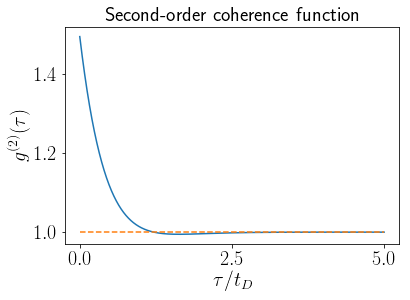

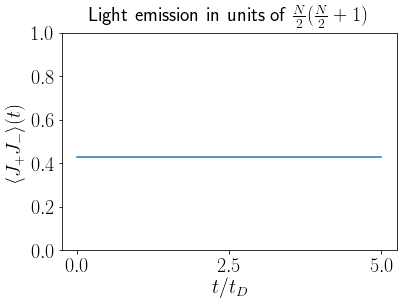

In [6]:
j2max = (0.5 * N + 1) * (0.5 * N)
label_size = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

fig1 = plt.figure()
plt.plot(t/td, g2t/nphot_ss**2, '-')
#plt.plot(t/td, 1+np.imag(g2t)/(jpjm_ss)**2, '-')
plt.plot(t/td, 1+0*g2t, '--')
plt.xlabel(r'$\tau/t_\text{D}$', fontsize = label_size)
plt.ylabel(r'$g^{(2)}(\tau)$', fontsize = label_size)
plt.title(r'Second-order coherence function', fontsize = label_size)
plt.xticks([0,(tmax/2)/td,tmax/td])
plt.show()
plt.close()


fig1 = plt.figure()
plt.plot(t/td, jpjmt/j2max, '-')
plt.xlabel(r'$t/t_\text{D}$', fontsize = label_size)
plt.ylabel(r"$\langle J_{+}J_{-}\rangle (t)$", fontsize = label_size)
plt.xticks([0,(tmax/2)/td,tmax/td])
plt.ylim([0,1])
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
plt.title(r"Light emission in units of $\frac{N}{2}(\frac{N}{2}+1)$", fontsize = label_size)
plt.show()
plt.close()

## 2) Maximum of light emission as a function of  $\frac{\gamma_\text{P}}{N\gamma_\text{CE}}$

We perform a study of the scaling of the steady state light emission of the system as a function of the pumping rate, normalized by the number of TLSs and the collective emission rate. The results show an optimal point for $\frac{\gamma_\text{P}}{N\gamma_\text{CE}}\simeq 1$ [1,2]. 

In [7]:
# Cycle on Coefficients
gCE = 1
gP0 = 1
gP_min_exp = -20
gP_max_exp = 20
gP_stepsize = 0.5
gP_list = np.arange(gP_min_exp, gP_max_exp+1, gP_stepsize)*0.1
gP_list_log = 10**(gP_list)

jpjmss_max_list = []
for i in gP_list_log:
    gP = i*gP0
    system = Dicke(hamiltonian = jz, N = N, pumping = gP, collective_emission = gCE)
    liouv = system.liouvillian()
    #steadystate
    rho_ss = steadystate(liouv)
    jpjm_ss = expect(jp*jm, rho_ss)
    jpjmss_max_list.append(jpjm_ss)

#### Visualization
We use the notation $\gamma_\uparrow=\gamma_\text{P}$ and $\gamma_\Downarrow=\gamma_\text{CE}$.

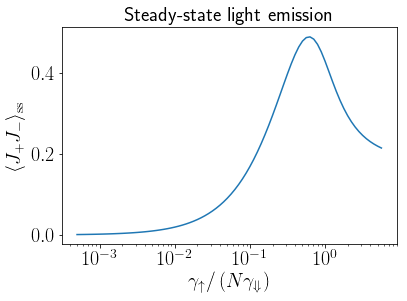

In [8]:
intensity_max = float(N)*gCE/2*(float(N)*gCE/2+1)
normalized_intensity = np.array(jpjmss_max_list)/intensity_max
plt.semilogx(gP_list_log/(gCE*N), normalized_intensity, '-')
label_size = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
#plt.xlabel(r'${\gamma_\mathrm{P}}/\left({N\gamma_\mathrm{CE}}\right)$', fontsize = label_size)
plt.xlabel(r'${\gamma_\uparrow}/\left({N\gamma_\Downarrow}\right)$', fontsize = label_size)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle_\mathrm{ss}$', fontsize = label_size)
fname = 'sssr_maxjpjm{}.pdf'.format(N)
savefigure = False
if savefigure == True:
    plt.savefig(fname, bbox_inches='tight')    
plt.title(r'Steady-state light emission', fontsize = label_size)
plt.show()

plt.close()

### Emission spectrum

#### Single TLS case: Mollow triplet in the resonance fluorescence spectrum

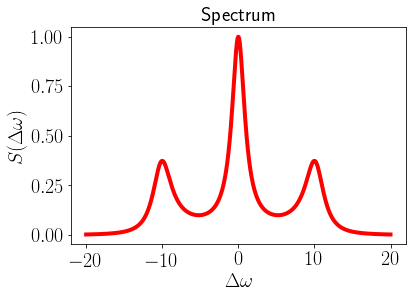

In [9]:
wz = 1
om = 5
gamm = 2
H = wz * sigmaz() + om * sigmax()
c_ops = [np.sqrt(gamm)*sigmam()]
a_op = sigmap()
b_op = sigmam()
wmin = - 20
wmax = 20
nw = 1000
wlist = np.linspace(wmin, wmax, nw)
liouv_TLS = liouvillian(H,c_ops)
sw = spectrum(liouv_TLS, wlist, [], a_op, b_op, solver="es", use_pinv=False)

smax = np.max(sw)
lw = 2
plt.plot(wlist, sw/smax, '-r', linewidth = 2*lw)
label_size = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
plt.xlabel(r'$\Delta\omega$', fontsize = label_size)
plt.ylabel(r'$S(\Delta\omega)$', fontsize = label_size)
plt.title(r'Spectrum', fontsize = label_size)
plt.show()
plt.close()

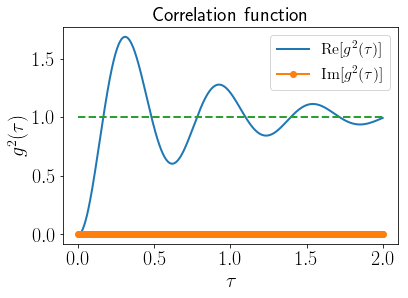

In [10]:
rhoss_TLS = steadystate(liouv_TLS)
B = sigmap() * sigmam()
jpjm_ss = expect(B, rhoss_TLS)
rhoB = sigmam() * rhoss_TLS * sigmap()
#Excited
t = np.linspace(0, 2, 1000)
options = Options(nsteps = 10000, atol = 1e-6)
result3 = mesolve(liouv_TLS, rhoB, t, [], e_ops = B, options = Options(store_states=True))
g2t = result3.expect[0]

taulist = t#np.linspace(0, 20, 100)
nphot_ss = expect(sigmap()*sigmam(), rhoss_TLS)
plt.plot(t, np.real(g2t)/nphot_ss**2, '-', linewidth = lw, label = r"$\mathrm{Re}[g^2(\tau)]$")
plt.plot(t, np.imag(g2t)/nphot_ss**2, '-o', linewidth = lw, label = r"$\mathrm{Im}[g^2(\tau)]$")
plt.plot(t, 1 +0*t , '--', linewidth = lw)
label_size = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
plt.xlabel(r'$\tau$', fontsize = label_size)
plt.ylabel(r'$g^{2}(\tau)$', fontsize = label_size)
plt.title(r'Correlation function', fontsize = label_size)
plt.legend(fontsize = label_size*0.8)
plt.show()
plt.close() 

#### $N>1$: Steady-state superradiance

In [11]:
N = 10
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jp.dag()

w0 = 20
g = 0
h0 = w0 * jz + g * jx 
gCE = 1.0
gD = .0
gP = N/2 * gCE
n_therm = 1

gE_list = [0, gP*(1+n_therm)]
system = Dicke(N = N)
gE = 0

system.hamiltonian = h0
system.collective_emission = gCE
system.emission = gE
system.pumping = gP
system.dephasing = gD
L = system.liouvillian()
rhoss = steadystate(L)
print(system)
td = np.log(N)/(N*gCE)
tmax = 100 * td
t = np.linspace(0, tmax, 2000)
dw = 10
wmin = w0 - dw
wmax = w0 + dw
nw = 100
wlist = np.linspace(wmin, wmax, nw)
lw = 3
#1
g2_norm, G2 = coherence_function_g2(L, None, t, [], jm, solver="me", args={},
                          options=Options(ntraj=[20, 100]))

g1_norm, G1 = coherence_function_g1(L, None, t, [], jm, solver="me", args={},
                          options=Options(ntraj=[20, 100]))

print("ok")
#swss = spectrum(L, wlist, [], jp, jm)
wlist, swss = spectrum_correlation_fft(t, g1_norm)

print("ok 2")
#2
g2_ss = correlation_2op_1t(L, rhoss, t, [], jp, jm)
#3
rho0 = dicke(N, N/2, -N/2)
#g2(tau)
rhoB = jm*rhoss*jp
result1 = mesolve(L, rhoB, t, [], e_ops = [jp*jm], options = Options(store_states=True))
print("ok 3")
g2t = result1.expect[0]
result2 = mesolve(L, rho0, t, [], e_ops = jp*jm, options = Options(store_states=True))
print("ok 4")
rhot = result2.states
jpjmt = result2.expect[0]
#g2t nat
Bn = jp * jm
jpjm_ss = expect(Bn, rhoss)
rhoBn = Bn * rhoss


N = 10
Hilbert space dim = (36, 36)
Number of Dicke states = 36
Liouvillian space dim = (1296, 1296)
pumping = 5.0
collective_emission = 1.0
ok
ok 2
ok 3
ok 4


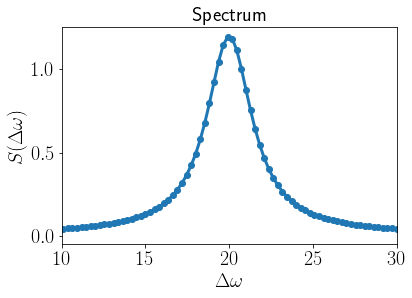

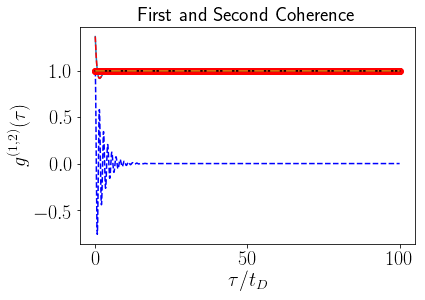

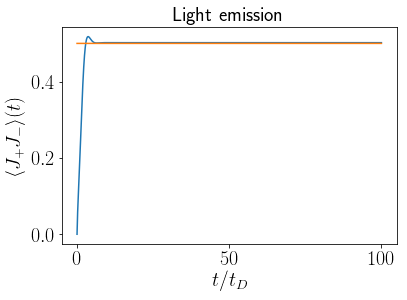

In [12]:
#1 Plot - Spectrum in frequency
plt.plot(wlist, swss, 'o-', linewidth = lw)
label_size = 20
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = label_size) 
plt.rc('ytick', labelsize = label_size)
plt.xlabel(r'$\Delta\omega$', fontsize = label_size)
plt.ylabel(r'$S(\Delta\omega)$', fontsize = label_size)
plt.title(r'Spectrum', fontsize = label_size)
plt.xlim([w0-10,w0+10])

plt.show()
plt.close()

#2 Plot 
j2max = (0.5 * N + 1) * (0.5 * N)

plt.rc('text', usetex = True)

fig1 = plt.figure()
plt.plot(t/td, np.real(g2t)/jpjm_ss**2, '-')
plt.plot(t/td, np.real(g2_norm), '--r')
plt.plot(t/td, np.real(g1_norm), '--b')
plt.plot(t/td, 1+np.imag(g2_norm), 'ro')
plt.plot(t/td, 1+np.imag(g2t), '-k')

plt.plot(t/td, 1+0*t, '-.')
plt.xlabel(r'$\tau/t_\text{D}$', fontsize = label_size)
plt.ylabel(r'$g^{(1,2)}(\tau)$', fontsize = label_size)
plt.title(r'First and Second Coherence', fontsize = label_size)
plt.xticks([0,(tmax/2)/td,tmax/td])
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
plt.show()
plt.close()

#3 Plot Light emission as a function of time
fig1 = plt.figure()
plt.plot(t/td, jpjmt/j2max, '-')
plt.plot(t/td, 0*t+0.5, '-')
plt.xlabel(r'$t/t_\text{D}$', fontsize = label_size)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle (t)$', fontsize = label_size)
plt.xticks([0,(tmax/2)/td,tmax/td])
plt.title(r'Light emission', fontsize = label_size)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
#plt.ylim([0,N])
plt.show()
plt.close()

In [13]:
## general formual for detailed balance (not used below)
# Bose-Einstein distribution determines the occupation number
frequency_hertz = 10**(13)
temperature_kelvin = 10**(6)
x = (frequency_hertz / temperature_kelvin) * (constants.hbar / constants.Boltzmann)
n0 = 1/(np.exp(x) -1)
print("occupation number, n0 = ",n0)

# set collective pumping and collective emission rates (coupled ensembles) 
g0 = 10
n0 = gP / g0 
gE = g0 * (1 + n0)
print(gE)
print(gP)

occupation number, n0 =  13091.5295848
15.0
5.0


In [14]:
# Do two nested cycles to calculate the dependency of the maximum superradiance peak on the pump rate

# compare the case of no loss (noloss) to the thermal case with detailed balance
#ntls list
ntls_list = np.linspace(10,40,4)
print(ntls_list)
#Coefficients
gCE = 1
gP0 = 1
gP_min_exp = -20
gP_max_exp = 20
gP_stepsize = 0.5
gP_list = np.arange(gP_min_exp, gP_max_exp+1, gP_stepsize)*0.1
gP_list_log = 10**(gP_list)
gP_gCE_N_list_log= 10**(gP_list)
max_nn_list = []
argmax_nn_list = []
normalized_intensity_list = []
max_nn_list_noloss = []
argmax_nn_list_noloss = []
normalized_intensity_list_noloss = []
lw_i = 0.5

[ 10.  20.  30.  40.]


In [15]:
# Do two nested cycles to calculate the dependency of the maximum superradiance peak on the pump rate
for nn in ntls_list:
    lw_i = lw_i + 0.5
    jpjm_max_list = []
    jpjm_max_arg_list = []
    jpjmss_max_list = []
    jpjm_max_list_noloss = []
    jpjm_max_arg_list_noloss = []
    jpjmss_max_list_noloss = []    
    N = int(nn)
    print(N)
    ntls = N
    jmax = (0.5 * N)
    j2max = (0.5 * N + 1) * (0.5 * N)
    intensity_max = float(N)*gCE/2*(float(N)*gCE/2+1)
    [jx, jy, jz] = jspin(N)
    jp = jspin(N, "+")
    jm = jp.dag()
    jpjm = jp*jm
    #time
    for i in gP_gCE_N_list_log:
        gP_gCE_N = i*gP0
        gP = gP_gCE_N*(gCE*N)
        gE = gP # fix the high temperature limit
        td0 = np.log(N)/(N*gCE)
        h = jz
        system = Dicke(hamiltonian = h, N = N, pumping = gP, 
                       collective_emission = gCE, emission = gE)
        system_noloss = Dicke(hamiltonian = h, N = N, pumping = gP, 
                              collective_emission = gCE, emission = 0.0*gE)
        liouv = system.liouvillian()
        liouv_noloss = system_noloss.liouvillian()
        #steadystate with loss
        rho_ss = steadystate(liouv)
        jpjm_ss = expect(jpjm, rho_ss)
        jpjmss_max_list.append(jpjm_ss)
        #steadystate no loss
        rho_ss_noloss = steadystate(liouv_noloss)
        jpjm_ss_noloss = expect(jpjm, rho_ss_noloss)
        jpjmss_max_list_noloss.append(jpjm_ss_noloss)
        #print("N=", N," gP/(N*gCE)=", gP/(N*gCE) )
    # emitted light with loss
    normalized_intensity = np.array(jpjmss_max_list)/intensity_max
    normalized_intensity_list.append(normalized_intensity) 
    argmax_nn = np.argmax(normalized_intensity)
    max_nn = np.max(normalized_intensity)
    max_nn_list.append(max_nn)
    argmax_nn_list.append(gP_list_log[argmax_nn])
    # emitted light no loss
    normalized_intensity_noloss = np.array(jpjmss_max_list_noloss)/intensity_max
    normalized_intensity_list_noloss.append(normalized_intensity_noloss) 
    argmax_nn_noloss = np.argmax(normalized_intensity_noloss)
    max_nn_noloss = np.max(normalized_intensity_noloss)
    max_nn_list_noloss.append(max_nn_noloss)
    argmax_nn_list_noloss.append(gP_list_log[argmax_nn_noloss])

10
20
30
40


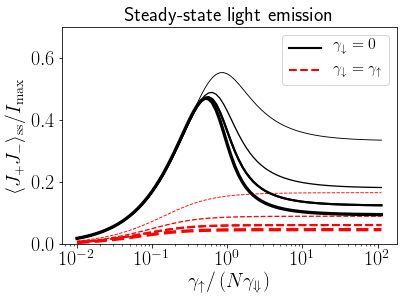

In [16]:
label_size = 20
label_size2 = 20
label_size3 = 20

plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

fig1 = plt.figure(1)
lw_i = 0.9
for i in range(0,len(normalized_intensity_list)):
    
    #cycle for all N values
    
    lw_i = lw_i + 0.4*i
    plt.semilogx(gP_gCE_N_list_log, normalized_intensity_list_noloss[i], 'k-',
                 lw = lw_i)
    plt.semilogx(gP_gCE_N_list_log, normalized_intensity_list[i], 'r--', lw = lw_i)
    
    # have legend with mid-sized line
    
    if i == len(normalized_intensity_list) -2:
        
        plt.semilogx(gP_gCE_N_list_log, normalized_intensity_list_noloss[i], 'k-',
                 lw = lw_i, label=r"$\gamma_\downarrow=0$")
        plt.semilogx(gP_gCE_N_list_log, normalized_intensity_list[i], 'r--', lw = lw_i,
                 label=r"$\gamma_\downarrow=\gamma_\uparrow$")

plt.xlabel(r'${\gamma_\uparrow}/\left({N\gamma_\Downarrow}\right)$', fontsize = label_size3)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle_\mathrm{ss}/I_\mathrm{max}$', fontsize = label_size3)
plt.ylim([0,0.7])
plt.legend(fontsize = label_size2*0.8)
fname = 'sssr_jpjmssmax_N{}gE_detailedbalance.pdf'.format(N)
if savefigure == True:
    plt.savefig(fname, bbox_inches='tight')
plt.title(r'Steady-state light emission', fontsize = label_size2)
plt.show()
plt.close()

#### References

[1] D. Meiser and M.J. Holland, Steady-state superradiance with alkaline-earth-metal atoms, *Phys. Rev. A* **81**, 033847 (2010)

[2] D. Meiser and M.J. Holland, Intensity fluctuations in steady-state superradiance, *Phys. Rev. A* **81**, 063827 (2010)

[3] J.G. Bohnet *et al.*, A steady-state superradiant laser with less than one intracavity photon, *Nature* **484**, 78 (2012)

[4]  N. Shammah, N. Lambert, F. Nori, and S. De Liberato,  Superradiance with local phase-breaking effects, *Phys. Rev. A* **96**, 023863 (2017)

[5] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, Open quantum systems with local and collective incoherent processes: Efficient numerical simulation using permutational invariance, **Phys. Rev. A 98, 063815 (2018)** https://arxiv.org/abs/1805.05129 and https://github.com/nathanshammah/piqs/

[6] J.R. Johansson, P.D. Nation, and F. Nori, *Comp. Phys. Comm.* **183**, 1760 (2012) http://qutip.org

In [17]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.0.dev0+cdc2204a
Numpy Version:      1.13.3
Scipy Version:      1.0.0
Cython Version:     0.27.3
Matplotlib Version: 2.1.1
Python Version:     3.6.3
Number of CPUs:     2
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/nathanshammah/Dropbox/GitHub/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.about.cite()`
